In [2]:
# -*- coding: utf-8 -*-

# 절대 임포트 설정
from __future__ import absolute_import
from __future__ import print_function

# 필요한 라이브러리들을 임포트
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf


In [3]:
# Step 1: 필요한 데이터를 다운로드한다.
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """파일이 존재하지 않으면 다운로드하고 사이즈가 적절한지 체크한다."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

# 문자열로 데이터를 읽는다
def read_data(filename):
  """zip파일 압축을 해제하고 단어들의 리스트를 읽는다."""
  with zipfile.ZipFile(filename) as f:
    data = f.read(f.namelist()[0]).split()
  return data

words = read_data(filename)
print('Data size', len(words))

Found and verified text8.zip
Data size 17005207


In [4]:
# Step 2: dictionary를 만들고 UNK 토큰을 이용해서 rare words를 교체(replace)한다.
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], (b'the', 1061396), (b'of', 593677), (b'and', 416629), (b'one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] [b'anarchism', b'originated', b'as', b'a', b'term', b'of', b'abuse', b'first', b'used', b'against']


In [5]:
# Step 3: skip-gram model을 위한 트레이닝 데이터(batch)를 생성하기 위한 함수.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 b'originated' -> 5234 b'anarchism'
3081 b'originated' -> 12 b'as'
12 b'as' -> 6 b'a'
12 b'as' -> 3081 b'originated'
6 b'a' -> 195 b'term'
6 b'a' -> 12 b'as'
195 b'term' -> 2 b'of'
195 b'term' -> 6 b'a'


In [6]:
# Step 4: skip-gram model 만들고 학습시킨다.

batch_size = 128
embedding_size = 128  # embedding vector의 크기.
skip_window = 1       # 윈도우 크기 : 왼쪽과 오른쪽으로 얼마나 많은 단어를 고려할지를 결정.
num_skips = 2         # 레이블(label)을 생성하기 위해 인풋을 얼마나 많이 재사용 할 것인지를 결정.

# sample에 대한 validation set은 원래 랜덤하게 선택해야한다. 하지만 여기서는 validation samples을 
# 가장 자주 생성되고 낮은 숫자의 ID를 가진 단어로 제한한다.
valid_size = 16     # validation 사이즈.
valid_window = 100  # 분포의 앞부분(head of the distribution)에서만 validation sample을 선택한다.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # sample에 대한 negative examples의 개수.

graph = tf.Graph()

with graph.as_default():

  # 트레이닝을 위한 인풋 데이터들
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # embedding vectors 행렬을 랜덤값으로 초기화
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # 행렬에 트레이닝 데이터를 지정
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # NCE loss를 위한 변수들을 선언
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # batch의 average NCE loss를 계산한다.
  # tf.nce_loss 함수는 loss를 평가(evaluate)할 때마다 negative labels을 가진 새로운 샘플을 자동적으로 생성한다.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # SGD optimizer를 생성한다.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # minibatch examples과 모든 embeddings에 대해 cosine similarity를 계산한다.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

In [19]:
hello_out = sess.run(embeddings)
print_tf(hello_out)

NameError: name 'sess' is not defined

In [7]:
embeddings

<tf.Variable 'Variable:0' shape=(50000, 128) dtype=float32_ref>

In [8]:
embed

<tf.Tensor 'embedding_lookup:0' shape=(128, 128) dtype=float32>

In [9]:
nce_weights

<tf.Variable 'Variable_1:0' shape=(50000, 128) dtype=float32_ref>

In [12]:
print(nce_biases)

<tf.Variable 'Variable_2:0' shape=(50000,) dtype=float32_ref>


In [15]:
optimizer

<tf.Operation 'GradientDescent' type=NoOp>

In [16]:
norm

<tf.Tensor 'Sqrt:0' shape=(50000, 1) dtype=float32>

In [17]:
normalized_embeddings

<tf.Tensor 'truediv:0' shape=(50000, 128) dtype=float32>

In [22]:
valid_embeddings

<tf.Tensor 'embedding_lookup_1:0' shape=(16, 128) dtype=float32>

In [18]:
similarity

<tf.Tensor 'MatMul_1:0' shape=(16, 50000) dtype=float32>

In [20]:
# Step 5: 트레이닝을 시작한다.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # 트레이닝을 시작하기 전에 모든 변수들을 초기화한다.
  tf.initialize_all_variables().run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # optimizer op을 평가(evaluating)하면서 한 스텝 업데이트를 진행한다.
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # 평균 손실(average loss)은 지난 2000 배치의 손실(loss)로부터 측정된다.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # nearest neighbors의 개수
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step  0 :  264.49017333984375
Nearest to b'in': b'somers', b'eloquent', b'bacillus', b'university', b'qua', b'arrests', b'blatantly', b'didache',
Nearest to b'six': b'intersputnik', b'poured', b'godly', b'heritability', b'jehoiachin', b'brahmin', b'bypasses', b'uncountably',
Nearest to b'to': b'regions', b'vah', b'flugelhorn', b'ncp', b'integrin', b'raeder', b'calculation', b'banishment',
Nearest to b'on': b'resignations', b'analyzing', b'daiko', b'musculoskeletal', b'robustus', b'assassin', b'mindset', b'rigor',
Nearest to b'but': b'sighting', b'sloping', b'stabilization', b'magma', b'theoretic', b'godfrey', b'army', b'coulomb',
Nearest to b'i': b'endowment', b'sported', b'dispersing', b'carloman', b'monosaccharides', b'minix', b'invitation', b'burnside',
Nearest to b'were': b'boating', b'offical', b'bsi', b'heating', b'ai', b'sacking', b'burgundian', b'framed',
Nearest to b'such': b'

Average loss at step  42000 :  5.286029880046844
Average loss at step  44000 :  5.281632693171501
Average loss at step  46000 :  5.263445863008499
Average loss at step  48000 :  5.033664837956429
Average loss at step  50000 :  5.148048001050949
Nearest to b'in': b'and', b'at', b'from', b'on', b'nine', b'of', b'during', b'thibetanus',
Nearest to b'six': b'four', b'eight', b'five', b'seven', b'three', b'nine', b'two', b'one',
Nearest to b'to': b'philosophically', b'would', b'for', b'can', b'agouti', b'reuptake', b'dasyprocta', b'nine',
Nearest to b'on': b'in', b'and', b'at', b'otimes', b'upon', b'for', b'dasyprocta', b'mathbf',
Nearest to b'but': b'and', b'however', b'which', b'reginae', b'though', b'or', b'vojt', b'dasyprocta',
Nearest to b'i': b'they', b'endowment', b'imperfective', b'syncretism', b'bed', b'angina', b'guderian', b'akita',
Nearest to b'were': b'are', b'was', b'have', b'is', b'be', b'had', b'by', b'been',
Nearest to b'such': b'well', b'these', b'kayaking', b'buckinghamsh

Average loss at step  92000 :  4.709150791883468
Average loss at step  94000 :  4.636258371949196
Average loss at step  96000 :  4.725686373949051
Average loss at step  98000 :  4.616494933247567
Average loss at step  100000 :  4.671715732812881
Nearest to b'in': b'during', b'cegep', b'tamias', b'at', b'on', b'from', b'within', b'callithrix',
Nearest to b'six': b'seven', b'five', b'four', b'eight', b'nine', b'three', b'two', b'zero',
Nearest to b'to': b'must', b'will', b'can', b'would', b'cegep', b'philosophically', b'agouti', b'marmoset',
Nearest to b'on': b'in', b'upon', b'at', b'cegep', b'during', b'tamias', b'through', b'callithrix',
Nearest to b'but': b'and', b'however', b'which', b'though', b'while', b'reginae', b'although', b'tamarin',
Nearest to b'i': b'they', b'you', b'ii', b't', b'syncretism', b'f', b'motors', b'akita',
Nearest to b'were': b'are', b'was', b'have', b'had', b'is', b'be', b'by', b'although',
Nearest to b'such': b'well', b'these', b'known', b'some', b'many', b'se

In [21]:
# Step 6: embeddings을 시각화한다.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn and matplotlib to visualize embeddings.")

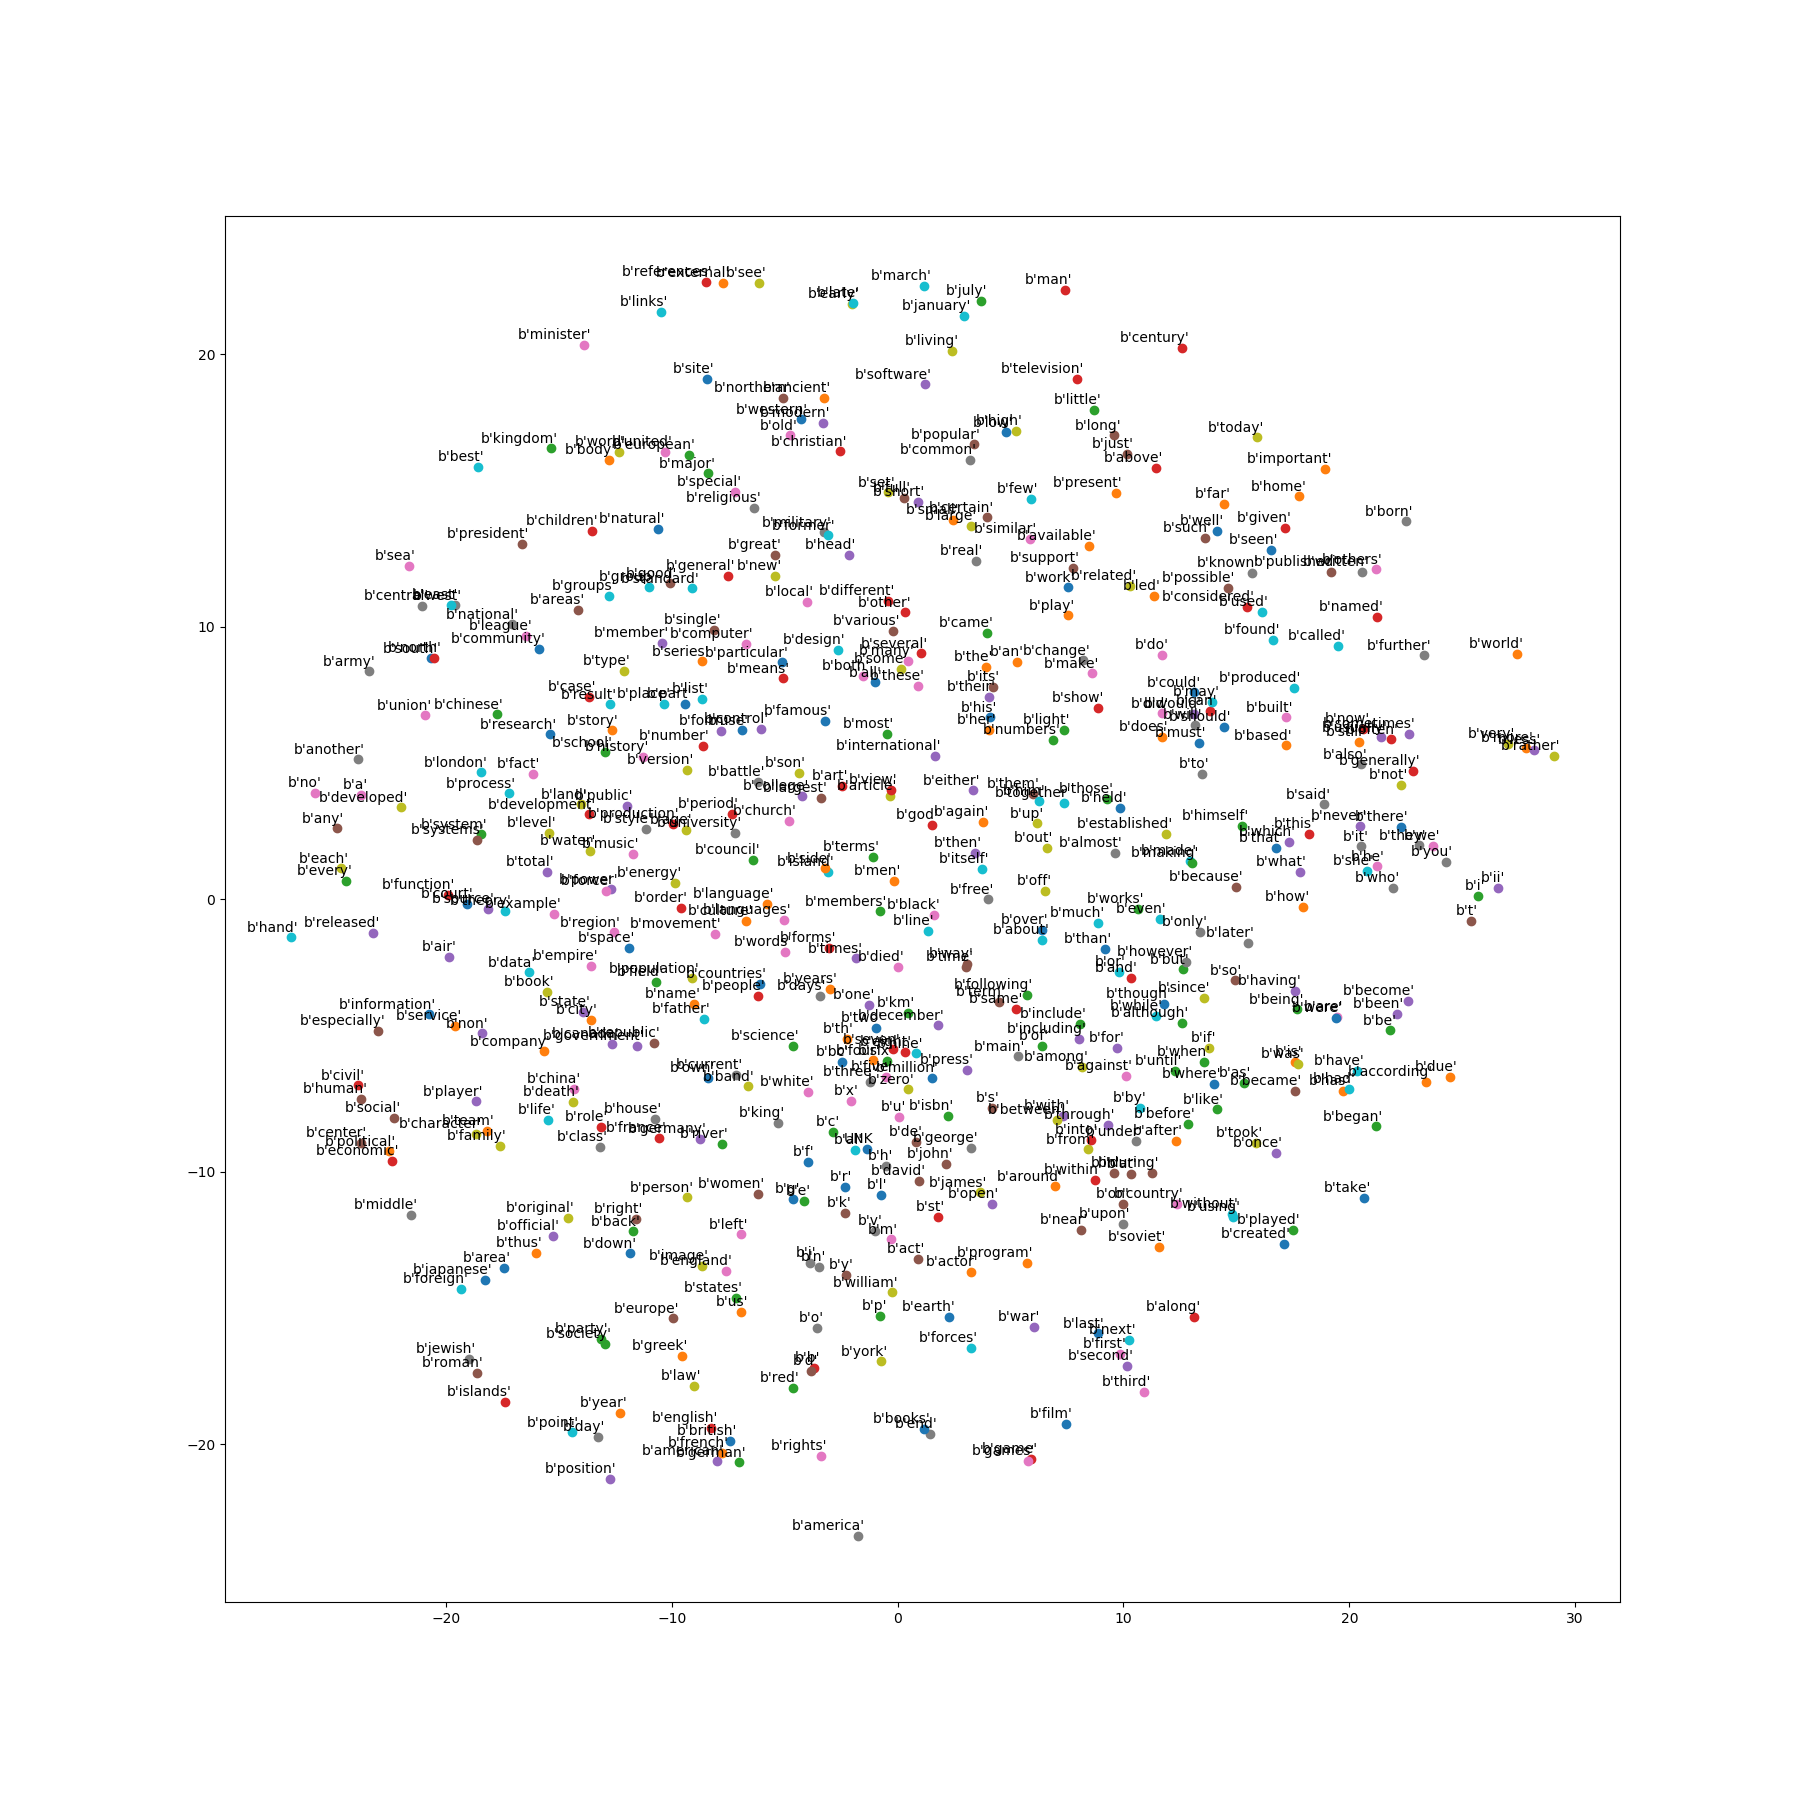

In [30]:
from IPython.display import Image
Image(filename='tsne.png')